<a href="https://colab.research.google.com/github/LachlanSharp/Lorem-ipsum/blob/main/A3_Deliverable_3_Lachlan_Sharp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MA5851 - Assessment 3: WebCrawler and NLP System

---

* **Task 3**: NLP Tasks
* **Author**: Lachlan Sharp
* **Due Date**: 2021-12-08

The following was the thried deliverable for the WebCrawler and NLP System, outlining the NLP component.

* *Note*: due to issues encountered rendering the notebook to a PDF files, images have been included twice: one to support the PDF render, and the other to support notebook (.ipynb) and HTML.

Artefacts of this project were published on GitHub: https://github.com/LachlanSharp/Lorem-ipsum.git 

---



# NLP System

## Rationale for NLP system

There have been numerous studies of ‘topic modelling’ in human healthcare (Prasad et al, 2021, and Valdez et al, 2021), as well as sentiment analysis (Zunic et al, 2020). However, little equivalent was found for animal health. 

As summarised by Valdez et al (2021), topic modelling has been applied to “identify salient themes found in large quantities of otherwise unstructured, nonnumeric data” (pp. 311). It has been utilised in the promotion of health education, and to track the development of “linguistic framing/word choice” over time within scientific fields.

Topic modelling has also been used to examine health concerns expressed on social media, such as “mental-well being during the COVID-19 pandemic” (Valdez et al, 2021, pp.311) and the influenza virus via Twitter. The *Horse Health* forum conceptually represents a similar data source for horse health issues as Twitter has for humans.

Sentiment analysis has been applied to the human perception of animal welfare (Dalla Costa et al, 2019), and the perception of veterinarians (Widmar, 2020). Yet nothing was found that applied sentiment analysis directly to animal health issues.

Hence this project attempts to broaden knowledge around horse health, by investigating the open question of whether the application of natural language processing (NLP) techniques provides any insights or opportunities for further study. This project implemented the following NLP system on posts from the *Horse Health* forum:

* Pre-processing of the data sourced from the WebCrawler.
* Topic modelling of each thread within the forum, utilising Latent Dirichlet Allocation (LDA) via the `genism` library.
* Sentiment analysis was applied to each thread using 'VADER', then aggregated with the labels applied during topic modelling.


## Data pre-processing

### Combining the datasets

There were three datasets resulting from the WebCrawler that needed to be consolidated:

1. ***Forum-threads*** (20,954 rows × 10 columns)
2. ***Thread-pages*** (24,627 rows × 3 columns)
3. ***Thread-posts*** (232,763 rows × 11 columns)

The initial wrangling steps were as follows:

* As a convenience and to aid understanding, features in the *forum-thread* dataset were renamed from “item_” to “thread_”.
* The participant count for each thread was aggregated from the *thread-pages* dataset and joined to the *forum-thread* dataset.
* The *thread-posts* needed to be consolidated into a single document per thread.


### Consolidating the thread corpus

Each thread consisted of multiple posts, where each unique post was its own observation. For topic modelling, the posts of each thread needed to be combined to create one "document" per thread. The wrangling steps were as follows:

1. Coalesce `NaN` values in the `post_text` feature to empty strings.
2. Group the dataset to produce a list of all posts for a given thread.
3. Concatenate the list of posts into a single document (string).
4. Combine the thread's title into the thread's document

Note that a post could be without any message text in circumstances where a user only posted an image (i.e., a picture of a horse). An example of such a post was provided via the following URL:

* https://www.horseforum.com/threads/putting-weight-on-an-older-horse.495553/#post-6402881 



### Pre-processing

Having consolidated the dataset, the corpus required further pre-processing. The following common cleaning tasks were performed:

* Removal of website URLs:
    + Total URLs found: 5,760
    + Unique URLs found: 4,531
    + Unique domains found: 1,716
* Removal of email addresses:
    + No email addresses were found.
* Removal of rogue HTML tags:
    + Two (2) HTML tags were found.
* Character encoding:
    + Conversion of Unicode characters to ASCII (using the `unidecode` library).
    + Un-escaping HTML escape characters using the `html` library.
* Replacement of new-line characters, “words” made up entirely of digits, and excess whitespace.

Note that for sentiment analysis, it was pertinent to keep character casing “as-is”, as was the retention of punctuation. This was because, by example, “AWESOME!!!” would carry a heavier emphasis of sentiment than “awesome”.
However, for topic modelling the following additional pre-processing steps were performed (that were not applied for sentiment analysis):

* Converting the corpus to lower character case.
* Removal of punctuation and other non-word characters.
* Removal of stopwords.
* Lemmatization (using `WordNetLemmatizer()` from the `nltk` library).
* Retention of the following part-of-speech (POS) tags:
    + Nouns
    + Adjectives
    + Verbs
    + Adverbs
* Formation of bigrams.
* Term weights were calculated as term frequency-inverse document frequency (TF-IDF).

A plot of word-frequency after the removal of stopwords, POS tags, and lemmatization was included as Figure 1.


---

#### Figure 1: Word-Frequency

![Fig. 1: Word-Frequency](lemmatized_word_freq.png)

In [40]:
%%html
<img src='https://drive.google.com/uc?export=view&id=1R8U3zW_cLgwIY0NPJbgNYIHpKUqGtSoM' alt="word-frquency" width="700"/>

---

## Hyperparameter selection

There were three aspects to the NLP system for which hyperparameters needed to be selected:

* The formation of bigrams.
* The filtering of “extreme” terms within the corpus.
* Parameters of the LDA topic model.


### Bigrams

For inclusion in the topic modelling analysis, it was nominated that a bigram needed to occur a minimum of five times within the corpus and overcome a “threshold score” of 100 (where higher thresholds results in fewer phrases).

There was no strong rationale for these choices over other values, though it was noted that at least six bigrams were in the “top 10: keywords in modelled topics (refer Appenidx, section 'Bigrams'):

* beet_pulp
* wolf_teeth
* equine_dentist
* proud_flesh
* rice_bran
* rain_rot

It was an area of modelling that would benefit from further trialling of values.


### Term threshold

Extreme terms were filtered from the analysis as follows:

* A term needed to appear a minimum of 100 times to be retained.
* A term could not appear in more than 75% of documents to be retained.
* A maximum of 150,000 terms were kept.
* The impact of changing these values required further assessment but was not conducted as part of this project. 


### LDA model

The LDA model had two hyperparameters of note, only one of which was tuned as part of this project:
The LDA model had two hyperparameters of note, only one of which was tuned.

* `passes`: Controls the number of passes through the corpus during training. The larger the corpus, the fewer passes required. For the size of this project’s corpus, two passes were deemed sufficient.
* `num_topics`: the number of topics to be modelled. This parameter was tuned by the project.

As shown in Figure 2, a range of topic numbers were trialled. Based on the resulting coherence score, **16 topics** was chosen as the **best model**. Hyper-tuning took approximately 1 hour with 4 workers (CPUs).


---

#### Figure 2: LDA Hyper-tuning

![Fig. 2: LDA Hyper-tuning](LDA_hypertune.png)

In [42]:
%%html
<img src='https://drive.google.com/uc?export=view&id=1wR0tGyeYRGGCTm_dBGRiKEyzKoSKwC6G' alt="LDA Hyper-tuning" width="600"/>

| Topic Number | Coherence |
|:------------:|:---------:|
|       4      | 0.5218    |
|       6      | 0.4829    |
|       8      | 0.5259    |
|      10      | 0.4657    |
|      12      | 0.464     |
|      14      | 0.522     |
|      16      | 0.5448    |
|      18      | 0.4926    |
|      20      | 0.517     |
|      22      | 0.4979    |
|      24      | 0.4563    |

---

## Preliminary assessment of performance

### Topic Modelling

Topic modelling of the *Horse Health* forum was performed via Latent Dirichlet Allocation (LDA) using the `genism` library. The “best” 16-topic model had a coherence score ($C\_v$) of 0.5448. The top 10 keywords from each of its topics were tabled below, and the distribution of the “primary” and “secondary” dominant topics across threads was shown in Figure 3. The most frequently occurring health topics were *Topic Id* ‘12’, followed by *Topic Id* ‘0’.

| Topic Id |  Word01  |   Word02  |   Word03   |  Word04  |    Word05   |  ...  |
|:--------:|:--------:|:---------:|:----------:|:--------:|:-----------:|:-----:|
|     0    |   feed   |    hay    | supplement |  weight  |    grain    |  ...  |
|     1    |   teeth  |  dentist  | wolf_teeth |   mouth  |    tooth    |  ...  |
|     2    |  farrier |    hoof   |    shoe    |   foot   |     vet     |  ...  |
|     3    |    hay   |   grass   |    feed    |  weight  |   alfalfa   |  ...  |
|     4    |   hoof   |    shoe   |   farrier  |   foot   |    thrush   |  ...  |
|     5    | cribbing |    crib   |   muscle   |  weight  |   blanket   |  ...  |
|     6    |   worm   |  vaccine  |  deworming | parasite |    wormer   |  ...  |
|     7    |   duck   | insurance |    hoof    |   foot   |   farrier   |  ...  |
|     8    |    leg   |    shoe   |    hoof    |    vet   |     sway    |  ...  |
|     9    |  saddle  |    hair   |    skin    |   tail   |   vaccine   |  ...  |
|    10    |   wound  |    leg    |    clean   |  sheath  | proud_flesh |  ...  |
|    11    |   feed   |    hay    |     oil    |  weight  |    ulcer    |  ...  |
|    12    |    vet   |    eye    |     leg    |   water  |    colic    |  ...  |
|    13    |    leg   |    lame   |    joint   | lameness |  arthritis  |  ...  |
|    14    |    fly   |  blanket  |    spray   |   skin   |     eye     |  ...  |
|    15    |    eye   |    worm   |     vet    |   sweat  |     hay     |  ...  |

| ...  |   Word06   |     Word07     |  Word08  |  Word09 |   Word10  | Topic Id |
|:----:|:----------:|:--------------:|:--------:|:-------:|:---------:|:--------:|
| ...  |   alfalfa  |    beet_pulp   |  feeding |  pellet |   ulcer   |     0    |
| ...  |  sedation  | equine_dentist |   float  |  canine |   dental  |     1    |
| ...  |   animal   |     people     |   owner  |   care  |    feed   |     2    |
| ...  |   pasture  |      bale      |   grain  | feeding |    eat    |     3    |
| ...  |    trim    |    barefoot    |   frog   |   boot  |    heel   |     4    |
| ...  |    foal    |      mare      |  collar  |  teeth  |   winter  |     5    |
| ...  | ivermectin |     worming    |   shot   |  rabies |  coggins  |     6    |
| ...  |     leg    |      shoe      |    vet   |   heel  |   injury  |     7    |
| ...  |    back    |     saddle     |    hay   |   foot  |    tail   |     8    |
| ...  |     fly    |       ear      |   mane   |  louse  |    vet    |     9    |
| ...h |     cut    |      water     |   wrap   |   skin  |    vet    |     10   |
| ...  | supplement |       fat      |  alfalfa |   cup   | rice_bran |     11   |
| ...  |    call    |      mare      | swelling |   back  |   stall   |     12   |
| ...  |    hock    |       vet      |  injury  |  stifle |    foot   |     13   |
| ...  |    hair    |    rain_rot    |   tick   |  cough  |    cold   |     14   |
| ...  |  sweating  |      wound     |   feed   |   fly   |    look   |     15   |

<div style="page-break-after: always;"></div>

---

#### Figure 3: Topic Label Frequency

![Fig. 3: Topic Label Frequency](topic_freq.png)

In [44]:
%%html
<img src='https://drive.google.com/uc?export=view&id=1bmLF81LmdHbGMbxUm3GiKgoQ5FLE95g0' alt="Topic Label Frequency" width="1200"/>

---

The coherence measure expresses how much the topics “overlap” each other, with higher scores indicating more distinguishable topics. A coherence score of 0.5448 indicated significant overlap of topic. This was visible from the topic keywords tabulated above. By visual inspection it was noted:

* Topic ‘0’ and topic ‘11’ both related to “feed” and “ulcers”.
* Topics ‘6’ and ‘15’ both relate to worming.
* Multiple topics related to ‘feed’.
* Multiple topics related to ‘feet’.

Additionally, it was noted that lemmatization was poorly performed within this project, though this was sometimes due to bigrams. Several (non-exhaustive) examples were provided below—any extension of this project’s work should prioritise this lemmatization issue:

* Topic ‘1’ includes the following related words:
    + ‘teeth’, ‘tooth’, ‘wolf_teeth’.
    + ‘dentist’, ‘dental’, equine_dentist’.
* Topic ‘5’ includes the following related words:
    + ‘crib’, ‘cribbing’.
* Topic ‘6’ includes the following related words:
    + ‘worm’, ‘deworming’, ‘wormer’, ‘worming’.

In comparison of this project to the study of Prasad et al, 2021, the following observations were made:

* The study of Prasad et al considered topic modelling of (human) health, but utilised “labelled” data (of prior studies) sourced from social media platform, ‘Twitter’.
* While LDA was utilised by Prasad et al, rather than determining the optimal number of topics via a given model, their study assessed the performance of different models for a pre-set number of topics (i.e., 2 thru 20 topics). By comparison, this project’s “best-model” of 16 topics was within that range.
* The dataset utilised by Prasad et al was comprised of “millions of tweets”, where a tweet has a maximum of 280 characters. By comparison, the average character length for a “post” for this project was 549 characters, and the average length of a thread was 6,137 characters. This would be equivalent to approximately 500,000 (half a million) tweets. Hence the datasets were of a similar magnitude.
* While this project used *coherence* as the model’s performance metric, Prasad et al utilised *precision*, *recall*, and *F-score*.


### Sentiment Analysis

Sentiment analysis was applied to each thread of the forum using 'VADER' (via the `nltk` library), then summarised with the topic labels applied during topic modelling. The “compound metric” from VADER was converted into a categorical variable for sentiment, based on the nominated criteria:

```
if compound >= 0.05 then: 'positive'
else if compound <= -0.05 then: 'negative'
else: 'neutral'
```

Figure 4 showed the overall distribution of sentiment on the *Horse Health* forum, where as Figure 5 showed the relative proportion of sentiments within any given topic. Overall, *positive* sentiment was significantly higher than *negative*, even within a topic. Due to the “tight” bounds place around *neutral* sentiment, it unsurprisingly contributed the lowest proportion.

An impetus for this project was to investigate whether any health topic was dominated by negative sentiment, as a reflection of severity of symptoms or outcomes. This did not appear to be the case, and it was surmised sentiment better reflected the good-will and gratitude of the Horse Forum community.



### Aggregation of sentiment

One aspect of sentiment analysis that this project was unable to develop was how sentiment should be aggregated. Summing the sentiments of multiple Twitter tweets, with their maximum 280 characters, might be appropriate. However, the thread “documents” of this project were significantly longer.

It was reasoned that if a *thread* had two posts, one “positive” and one “negative”, this dichotomy would be lost if they were aggregated (as by this project) to cancel each other out as “neutral”. Hence a better approach may have been to determine the sentiment for each post individually. Yet there still would have been a need to normalize sentiment over so many posts, where a *positive*-post with 10 characters may not be viewed equivalent to a *positive*-post with 1000 characters.

Furthermore, the dataset also included user reactions (i.e., “Likes”) for each post. How this feature should be aggregated with the sentiment analysis was beyond the scope of this project. 

It was also noted in the sourcing of this dataset via the WebCrawler, that only examples of a “Like” react were observed, but no “Dislikes”. Hence it was possible that either the WebCrawler failed to scrape “Dislikes”, or that “Dislikes” were not possible within the forum. The semantics is important as it could change the interpretation of a “Like” from a straightforward “positive” sentiment adder to a weight or emphasis to the sentiment of the post—for example, “Likes” of a negative-sentiment post would add weight to that negative sentiment.

---

#### Figure 4: Overall forum sentiment

![Fig. 4: Overall forum sentiment](forum_sentiment.png)

In [46]:
%%html
<img src='https://drive.google.com/uc?export=view&id=1o9uipKH-NFNJ6MkXQaas77XBcvkcRvi7' alt="Overall forum sentiment" width="700"/>

---

#### Figure 5: Relative sentiment proportion per topic

![Fig. 5: Relative sentiment proportion per topic](topic_sentiment2.png)

In [48]:
%%html
<img src='https://drive.google.com/uc?export=view&id=1GuemhaO595oodzHzmVGvtobnqfjfAlhg' alt="Relative sentiment proportion per topict" width="450"/>

# References

Dalla Costa, E., Tranquillo, V., Dai, F., Minero, M., Battini, M., Mattiello, S., Barbieri, S., Ferrante, V., Ferrari, L., Zanella, A., & Canali, E. (2019). Text mining analysis to evaluate stakeholders’ perception regarding welfare of equines, small ruminants, and turkeys. *Animals*, 9(5). https://doi.org/10.3390/ani9050225 

Prasad, K., Mohammed, M., & Noorullah, R. M. (2021). Visual topic models for healthcare data clustering. *Evolutionary Intelligence*, 14. https://doi.org/10.1007/s12065-019-00300-y 

Valdez, D., Picket, A. C., Young, B.-R., & Golden, S. (2021). On mining words: The utility of topic models in health education research and practice. *Health Promotion Practice*, 22(3), 309–312. https://doi.org/10.1177/1524839921999050 

Widmar, N., Bir, C., Lai, J., & Wolf, C. (2020). Public Perceptions of Veterinarians from Social and Online Media Listening. *Veterinary sciences*, 7(2), 75. https://doi.org/10.3390/vetsci7020075

Zunic, A., Corcoran, P., & Spasic, I. (2020). Sentiment analysis in health and well-being: Systematic review. *JMIR Med Inform*, 8(1), e16023. https://doi.org/10.2196/16023 


<div style="page-break-after: always;"></div>

---

# Appendix - Python Coding

The NLP system was also implemented in Python, and performed the following steps:

* Pre-processing of the data sourced from the WebCrawler.
* Topic modelling of each thread within the forum, utilising Latent Dirichlet Allocation (LDA) via the `gensim` library.
* entiment analysis was applied to each thread using 'VADER', then aggregated with the labels applied during topic modelling.

This Python notebook was created using Google Colab (https://research.google.com/colaboratory/faq.html).

## Setup of data-project 

### Import Dependencies

In [33]:
import os.path # Operating system interface

import numpy as np # array/matrices support
import pandas as pd # data analaysis

# plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # statistical data visulisation

import random # Generate pseudo-random numbers

import gensim # Topic modelling
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases

import nltk # Natural Language Toolkit
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

!pip install unidecode
from unidecode import unidecode # ASCII representation of Unicode strings
import html # HyperText Markup Language support
import re # regular expressions

from pprint import pprint # Data pretty printer

# Get python version
import platform # Platform’s identifying data
print('\nPython version {}'.format(platform.python_version()))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!

Python version 3.7.12


### User defined functions


In [34]:
def mk_dir(path):
    """
    Creates a directory if it doesn't exist

    Parameters:
    -----------
    str : path
        The full directory path for the folder to be created.
        Note: the path should not terminate with a '/'

    Returns:
    --------
    bool
        If folder exists, True, otherwise, False
    """
    if not os.path.exists(path):
        try:
            os.makedirs(path)
        except:
            pass
    return os.path.exists(path)


def print_column_search_contains(df, pattern, print_long = True, max_print_per_feature = 1000):
    """
    Iterates through the columns of a dataframe and prints entry which
    contain matches to the passed regex pattern.

    The function is intended as data exploration tool.
    """

    for colname in df.select_dtypes(include='object').columns:
        print(colname)
        print("`{}`\t(First {} results)".format(colname, max_print_per_feature))
        print("========================")
        string_list = [val for val in df[colname] if isinstance(val, str)]
        string_list = [string for string in string_list if bool(re.search(pattern, string))]
        if print_long:
            for x in string_list[:max_print_per_feature]:
                print(x)           
        else:
            print(string_list[:max_print_per_feature])
        print()




def get_column_search_findall(df, pattern, unique_only=True):
    """
    Iterates through the columns of a dataframe and prints entry which
    contain matches to the passed regex.

    The function is intended as data exploration tool.
    """
    search_results = []
    for colname in df.select_dtypes(include='object').columns:
        string_list = [val for val in df[colname] if isinstance(val, str)]
        string_list = [re.findall(pattern, string) for string in string_list if bool(re.search(pattern, string))]
        for string in string_list:
            search_results.append(string)
    
    search_results = sum(search_results,[])
    if unique_only:
        search_results = list(set(search_results))
    return search_results



def set_dictionary_subst(oldtext_list, newtext = ''):
    """
    Creates a dictionary of replacement values for use with pandas 
    `.replace()` method.

    Implementation would be as follows:

        subst_dict = set_dictionary_subst(oldtext_list, newtext = '')
        df.replace(to_replace = replace_dict, regex = True)

    Parameter:
    ----------
    oldtext : list (of str)
        A list of strings to be replaced
    newtext: str
        A text value to be substituted

    Returns:
    --------
    dict
        A dictionary of regex escaped entries consisting of
            oldtext : newtext
    """

    if isinstance(oldtext_list, list):
        # Get unique entries by converting the list to a set
        subst_dict = {re.escape(oldtext) : newtext for oldtext in set(oldtext_list)}
    elif isinstance(oldtext_list, set):
        # Convert to dictionary
        subst_dict = {re.escape(oldtext) : newtext for oldtext in oldtext_list}        
    elif isinstance(oldtext_list, dict):
        subst_dict = oldtext_list
    else:
        subst_dict = oldtext_list
        print(f'parameter `oldtext_list` unexpected type: {type(oldtext_list)}')

    return subst_dict



def stop_and_lemm(document
                  ,stopwords
                  ,lemmatizer
                  ,retain_pos={ 'ALL' : '.' }
                  ):
    """
    Removes stopwords from a document and performs stemming.

    Parameters:
    -----------
    document : str
        the text to be processed
    stopwords : list[str]
        a list of words to be removed
    lemmatizer : function (e.g. nltk.stem.wordnet.WordNetLemmatizer)
        a function that can perform lemmatization using a `.lemmatize()` method
    dict : retain_pos
        a dictionary specifiy which parts of speach (POS) should be retained.
        e.g. {'NOUN' : 'N', 'ADJ' : 'J', 'VERB' : 'V', 'ADV' : 'R' }
        - dictionary values are used to generate a regex for the POS tag match
        - dictionary key are for readability only


    Returns:
    -------
    str
        the document text after processing
    """

    # Split document into a list of individual words
    word_tokens = word_tokenize(document) # nltk
    
    # Retain part of speach tags
    if retain_pos is not None and len(retain_pos) > 0:
        regex_pos = "^(" + "|".join(retain_pos.values()) + ")"    
        pos_tokens = pos_tag(word_tokens)
        word_tokens = [token for token, pos in pos_tokens if bool(re.search(regex_pos, pos))]

    # Lematization and removal of stopwords
    word_tokens = [lemmatizer.lemmatize(token) for token in word_tokens if token not in set(stopwords)]

    # Rejoin text
    document = ' '.join(word_tokens)
    return document



def word_frequencies(corpus, top_n = 50):
    """
    Generates a tally of word frequency from a body of text

    Paramters:
    ---------
    corpus : 
        an iterable object of text documents
    top_n : int
        The top-n occuring words by frequency

    Returns:
    --------
    pandas.dataframe
        A dataframe of two columns: 'word' and 'count'

    """

    all_words = ' '.join([document for document in corpus]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    df_words = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
    
    # selecting top-n most frequent words 
    return df_words.nlargest(columns="count", n = top_n)



def hypertune_LDA_num_topics(dictionary, corpus, texts, num_topics_seq):
    """
    Compute coherence score for various number of topics

    Parameters:
    ----------
    dict : dictionary
        Gensim dictionary
    corpus : corpus
        Gensim corpus
    list of [list of str] : texts
        A list of documents, where each document is a list of words.
    list of int: num_topics_seq
        A list of num_topics values, e.g., [10, 25, 50] etc.

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in num_topics_seq:
        print("Modeling {} topics...".format(num_topics))
        model = gensim.models.LdaMulticore(
            corpus=corpus
            ,id2word=dictionary    
            ,num_topics=num_topics
            ,passes=2
            ,random_state=987
            ,per_word_topics=True
            ,workers=4
            )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    print("...completed")
    return model_list, coherence_values





# Get the dominant topics for each document
def get_lda_dominant_topics(lda_model, corpus, top_n_words=10, delim_words=','):

    # Initialise result set
    df_topics = pd.DataFrame()

    for index_doc, c in enumerate(lda_model[corpus]):
        # Initalise results for document
        topic1_id = -1
        topic1_wt = 0
        topic1_words = ""    
        topic2_id = -1
        topic2_wt = 0
        topic2_words = ""  

        # sort topics in decreasing order of contribution
        topics = sorted(c[0], key = lambda x: x[1], reverse=True)

        if len(topics) > 0:         
            topic1 = topics[0]
            topic1_id = topic1[0]
            topic1_wt = topic1[1]
            topic1_show = best_model.show_topic(topicid=topic1_id ,topn=top_n_words)
            topic1_words = [word for word, wt in topic1_show]
            topic1_words = delim_words.join(topic1_words)

        if len(topics) > 1:
            topic2 = topics[1]
            topic2_id = topic2[0]
            topic2_wt = topic2[1]
            topic2_show = best_model.show_topic(topicid=topic2_id ,topn=top_n_words)
            topic2_words = [word for word, wt in topic2_show]
            topic2_words = delim_words.join(topic2_words)

        # Append to result set
        df_topics = df_topics.append(
            pd.Series([int(index_doc), int(topic1_id), topic1_wt, topic1_words, int(topic2_id), topic2_wt, topic2_words])
            ,ignore_index=True
            )

    # Set column names & data types
    df_topics.columns = ['index_doc', 'Primary_topic', 'Primary_topic_contribution', 'Primary_topic_keywords', 'Secondary_topic', 'Secondary_topic_contribution', 'Secondary_topic_keywords']
    df_topics = df_topics.astype({'index_doc': 'int64', 'Primary_topic': 'int64', 'Secondary_topic': 'int64'}, errors='ignore')
    return df_topics



def sentiment_colours():
    return { 'positive' : 'C0', 'neutral' : 'black', 'negative' : 'C1' }

### Set directory paths

This section sets pertinent file paths and names. The expected folder structure for this assessment was documented below.

```
working-dir/
├─ data/
│  ├─ df_horseforum_thread_pages.csv       {generated by WebCrawler}
│  ├─ df_horseforum_thread_posts.csv       {generated by WebCrawler}
│  ├─ df_horseforum_threads.csv            {generated by WebCrawler}
│  ├─ df_tophorse_item_details.csv         {generated by WebCrawler}
│  ├─ df_tophorse_items.csv                {generated by WebCrawler}
├─ A3_Deliverable_3_Lachlan_Sharp.ipynb    {Python Jupyter notebook}

```

#### Mount Google Drive

This section applies to use of this Python notebook within Google Colab.

In [35]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Set file paths

In [36]:
# Set directory paths root filepath for data-project
filepath_root = '/content/drive/MyDrive/Colab Notebooks/MA5851/Assessment 3' # data-project root
filepath_data = os.path.join(filepath_root, 'data') # data folder
print("Directory 'data' exists?: {}".format(mk_dir(filepath_data)))

# Set filenames
filename_tophorse_items_df = "df_tophorse_items.csv"
filename_tophorse_item_details_df = "df_tophorse_item_details.csv"

filename_horseforum_threads_df = "df_horseforum_threads.csv" 
filename_horseforum_thread_posts_df = "df_horseforum_thread_posts.csv"
filename_horseforum_thread_pages_df = "df_horseforum_thread_pages.csv"

filename_horseforum_threads_cleaned_df = "df_horseforum_threads_cleaned.csv" 

Directory 'data' exists?: True


## Import data

### Load WebCralwer data

Load data obtained via the web crawler.

In [28]:
df_horseforum_threads_raw = pd.read_csv(os.path.join(filepath_data, filename_horseforum_threads_df))
print("Re-imported threads data: {x[0]} rows × {x[1]} cols".format(x = df_horseforum_threads_raw.shape))
df_horseforum_thread_posts_raw = pd.read_csv(os.path.join(filepath_data, filename_horseforum_thread_posts_df))
print("Re-imported posts data: {x[0]} rows × {x[1]} cols".format(x = df_horseforum_thread_posts_raw.shape))
df_horseforum_thread_pages_raw = pd.read_csv(os.path.join(filepath_data, filename_horseforum_thread_pages_df))
print("Re-imported pages data {x[0]} rows × {x[1]} cols".format(x = df_horseforum_thread_pages_raw.shape))

Re-imported threads data: 20954 rows × 10 cols
Re-imported posts data: 232763 rows × 11 cols
Re-imported pages data 24627 rows × 3 cols


### Explore

In [ ]:
df_horseforum_thread_posts_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232763 entries, 0 to 232762
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   thread_url_path          232763 non-null  object 
 1   post_id                  232763 non-null  object 
 2   post_number              232763 non-null  float64
 3   post_url_path            232763 non-null  object 
 4   post_reactions_url_path  45707 non-null   object 
 5   post_reactions           45707 non-null   object 
 6   post_datetime            232763 non-null  object 
 7   post_username            232760 non-null  object 
 8   post_userid              232760 non-null  float64
 9   post_user_url_path       232760 non-null  object 
 10  post_text                232750 non-null  object 
dtypes: float64(2), object(9)
memory usage: 19.5+ MB


Feature post_text was NaN in case where a user only posted and image (i.e., a picture of a horse) but no text.

In [ ]:
df_horseforum_thread_posts_raw[df_horseforum_thread_posts_raw['post_text'].isnull()]

,thread_url_path,post_id,post_number,post_url_path,post_reactions_url_path,post_reactions,post_datetime,post_username,post_userid,post_user_url_path,post_text
63360,/threads/putting-weight-on-an-older-horse.495553/,post-6402881,2.0,/threads/putting-weight-on-an-older-horse.4955...,NaN,NaN,2014-10-17T21:02:54-0400,Becca76,148297.0,/members/becca76.148297/,NaN
69312,/threads/rebuilding-belle-improving-topline-an...,post-5435290,18.0,/threads/rebuilding-belle-improving-topline-an...,/posts/5435290/reactions/,Like (1),2014-05-21T10:32:02-0400,Clava,19244.0,/members/clava.19244/,NaN
74637,/threads/my-horse-has-bald-spots-lice-rain-rot...,post-5210186,2.0,/threads/my-horse-has-bald-spots-lice-rain-rot...,NaN,NaN,2014-04-19T01:16:46-0400,bludog,74258.0,/members/bludog.74258/,NaN
80942,/threads/need-help.329249/,post-4314241,6.0,/threads/need-help.329249/post-4314241,NaN,NaN,2013-12-15T22:25:42-0500,MoonshinePaint,57690.0,/members/moonshinepaint.57690/,NaN
80944,/threads/need-help.329249/,post-4314345,8.0,/threads/need-help.329249/post-4314345,NaN,NaN,2013-12-15T22:43:46-0500,MoonshinePaint,57690.0,/members/moonshinepaint.57690/,NaN
80945,/threads/need-help.329249/,post-4314369,9.0,/threads/need-help.329249/post-4314369,NaN,NaN,2013-12-15T22:45:47-0500,MoonshinePaint,57690.0,/members/moonshinepaint.57690/,NaN
80946,/threads/need-help.329249/,post-4314393,10.0,/threads/need-help.329249/post-4314393,NaN,NaN,2013-12-15T22:47:00-0500,MoonshinePaint,57690.0,/members/moonshinepaint.57690/,NaN
80947,/threads/need-help.329249/,post-4314401,11.0,/threads/need-help.329249/post-4314401,NaN,NaN,2013-12-15T22:47:32-0500,MoonshinePaint,57690.0,/members/moonshinepaint.57690/,NaN
80948,/threads/need-help.329249/,post-4314441,12.0,/threads/need-help.329249/post-4314441,NaN,NaN,2013-12-15T22:50:35-0500,MoonshinePaint,57690.0,/members/moonshinepaint.57690/,NaN
80956,/threads/need-help.329249/,post-4314833,20.0,/threads/need-help.329249/post-4314833,NaN,NaN,2013-12-15T23:41:06-0500,MoonshinePaint,57690.0,/members/moonshinepaint.57690/,NaN


### Wrangle

#### Rename `df_horseforum_threads` columns

In [7]:
df_horseforum_threads_raw.rename(
    {colname: colname.replace("item_", "thread_") for colname in df_horseforum_threads_raw.columns}
    ,axis=1
    ,inplace=True
     )
df_horseforum_threads_raw.head()

,thread_title,thread_url_path,thread_created_date,thread_created_by,thread_created_by_url_path,thread_view_count,thread_reply_count,thread_last_replied_date,thread_last_replied_by,thread_last_replied_by_url_path
0,PLEASE READ BEFORE POSTING (both older and new...,/threads/please-read-before-posting-both-older...,2020-12-27T19:19:33-0500,TaMMa89,/members/tamma89.3542/,1076,0,2020-12-27T19:19:33-0500,TaMMa89,/members/tamma89.3542/
1,poisonous plants from HF member locations,/threads/poisonous-plants-from-hf-member-locat...,2018-01-01T22:03:05-0500,Smilie,/members/smilie.18361/,2151,5,2020-12-08T16:29:12-0500,stevenson,/members/stevenson.26572/
2,The Care of an Emaciated Horse,/threads/the-care-of-an-emaciated-horse.100412/,2011-10-14T09:02:04-0400,xxBarry Godden,/members/xxbarry-godden.9451/,48970,54,2020-11-26T10:09:30-0500,horselovinguy,/members/horselovinguy.79162/
3,Making a Vet Kit,/threads/making-a-vet-kit.251/,2007-01-07T02:14:09-0500,Skippy!,/members/skippy.157/,2091441,277,2019-08-26T04:44:59-0400,AmiraAchek,/members/amiraachek.280747/
4,"Information on Myopathies - PSSM1, PSSM2, MFM,...",/threads/information-on-myopathies-pssm1-pssm2...,2017-08-17T20:06:14-0400,Espy,/members/espy.168162/,17546,5,2018-09-17T16:44:33-0400,Espy,/members/espy.168162/


#### Thread's participant count

Participant count for each *thread* was captured (repeatedly) from each of the thread's *pages*. The following combines the `participant_count` feature into the main *thread* dataset.

* *Note*: Participant count could have also been derived via agreggation of the `df_horseforum_thread_posts_raw` dataset.

In [8]:
# Convert `participant_count` to integer
df_horseforum_thread_pages_raw[['participant_count']] = df_horseforum_thread_pages_raw[['participant_count']].fillna(value=0)
df_horseforum_thread_pages_raw['participant_count'] = df_horseforum_thread_pages_raw['participant_count'].apply(int)
df_horseforum_thread_pages_raw[df_horseforum_thread_pages_raw['participant_count'] == 0]

,thread_url_path,participant_count,page_url_path
2642,/threads/dealing-with-paddock-boredom.781858/,0,/threads/dealing-with-paddock-boredom.781858/
2643,/threads/hock-degloving-graphic.781938/,0,/threads/hock-degloving-graphic.781938/
2644,/threads/feed-suggestions.781770/,0,/threads/feed-suggestions.781770/
2645,/threads/question-about-vaccinations.781673/,0,/threads/question-about-vaccinations.781673/
8189,/threads/which-joint-supplements-do-you-use-fo...,0,/threads/which-joint-supplements-do-you-use-fo...


In [9]:
# Add `participant_count` feature to the "thread" dataset (from "pages" dataset)
df_horseforum_threads = pd.merge(
    df_horseforum_threads_raw
    ,df_horseforum_thread_pages_raw.drop(['page_url_path'], axis=1).drop_duplicates()
    ,how='left'    
    ,left_on='thread_url_path'
    ,right_on='thread_url_path'
    )

df_horseforum_threads

,thread_title,thread_url_path,thread_created_date,thread_created_by,thread_created_by_url_path,thread_view_count,thread_reply_count,thread_last_replied_date,thread_last_replied_by,thread_last_replied_by_url_path,participant_count
0,PLEASE READ BEFORE POSTING (both older and new...,/threads/please-read-before-posting-both-older...,2020-12-27T19:19:33-0500,TaMMa89,/members/tamma89.3542/,1076,0,2020-12-27T19:19:33-0500,TaMMa89,/members/tamma89.3542/,1
1,poisonous plants from HF member locations,/threads/poisonous-plants-from-hf-member-locat...,2018-01-01T22:03:05-0500,Smilie,/members/smilie.18361/,2151,5,2020-12-08T16:29:12-0500,stevenson,/members/stevenson.26572/,5
2,The Care of an Emaciated Horse,/threads/the-care-of-an-emaciated-horse.100412/,2011-10-14T09:02:04-0400,xxBarry Godden,/members/xxbarry-godden.9451/,48970,54,2020-11-26T10:09:30-0500,horselovinguy,/members/horselovinguy.79162/,31
3,Making a Vet Kit,/threads/making-a-vet-kit.251/,2007-01-07T02:14:09-0500,Skippy!,/members/skippy.157/,2091441,277,2019-08-26T04:44:59-0400,AmiraAchek,/members/amiraachek.280747/,215
4,"Information on Myopathies - PSSM1, PSSM2, MFM,...",/threads/information-on-myopathies-pssm1-pssm2...,2017-08-17T20:06:14-0400,Espy,/members/espy.168162/,17546,5,2018-09-17T16:44:33-0400,Espy,/members/espy.168162/,2
...,...,...,...,...,...,...,...,...,...,...,...
20949,Recovery from Torn Rear Suspensory Ligament,/threads/recovery-from-torn-rear-suspensory-li...,2006-12-22T05:26:11-0500,trusspt,/members/trusspt.170/,6106,1,2006-12-30T04:51:20-0500,stacyh,/members/stacyh.186/,2
20950,how to get horses to gaine weight,/threads/how-to-get-horses-to-gaine-weight.99/,2006-12-05T11:54:51-0500,nybarrelracer,/members/nybarrelracer.121/,4988,14,2006-12-21T07:55:03-0500,brandig,/members/brandig.57/,9
20951,PAXIL?,/threads/paxil.102/,2006-12-06T10:09:20-0500,tuffstuff,/members/tuffstuff.123/,3240,3,2006-12-11T20:29:12-0500,kristy,/members/kristy.132/,4
20952,Loose stool,/threads/loose-stool.101/,2006-12-05T18:42:31-0500,Cedarsgirl,/members/cedarsgirl.120/,5694,10,2006-12-10T21:52:11-0500,Cedarsgirl,/members/cedarsgirl.120/,4


#### Consolidate thread corpus

Each *thread* consisted of multiple *posts*, where each unique post is its own observation. For the purpose topic modelling, the posts of each thread need to be combined to create one "document" per thread. The wrangling steps were as follows:

1. Coalesce `NaN` values in the `post_text` feature to empty strings.
2. Group the dataset to produce a list of all posts for a given thread.
3. Concatenate the list of posts into a single document (string).
4. Combine the thread's title into the thread's document

In [10]:
# Initialise a "processed" version of the orginal data frame
df_horseforum_thread_posts = df_horseforum_thread_posts_raw.copy()

# Convert NaN to empty string
df_horseforum_thread_posts[['post_text']] = df_horseforum_thread_posts[['post_text']].fillna(value="")

In [11]:
# Group by feature `thread_url_path` to aggregate feature `post_text` into a `list`.
tmpdf = df_horseforum_thread_posts.groupby(['thread_url_path'], as_index = False).agg({'post_text': list})

# Concatenate a thread's posts into a single document
tmpdf['thread_document'] = tmpdf['post_text'].apply('\n'.join)

In [12]:
# Combine the aggregated post features into the main thread data frame
df_horseforum_threads = pd.merge(
    df_horseforum_threads.drop(['post_text','thread_document']
                               ,axis=1
                               ,errors='ignore' # in case cell run multiple times
                               ) 
    ,tmpdf
    ,how='left'    
    ,left_on='thread_url_path'
    ,right_on='thread_url_path'
    )

# Convert NaN to empty string (occured because of the join)
df_horseforum_threads[['thread_document']] = df_horseforum_threads[['thread_document']].fillna(value="")

df_horseforum_threads['thread_document'] = df_horseforum_threads['thread_title'] + "\n" + df_horseforum_threads['thread_document']

df_horseforum_threads

,thread_title,thread_url_path,thread_created_date,thread_created_by,thread_created_by_url_path,thread_view_count,thread_reply_count,thread_last_replied_date,thread_last_replied_by,thread_last_replied_by_url_path,participant_count,post_text,thread_document
0,PLEASE READ BEFORE POSTING (both older and new...,/threads/please-read-before-posting-both-older...,2020-12-27T19:19:33-0500,TaMMa89,/members/tamma89.3542/,1076,0,2020-12-27T19:19:33-0500,TaMMa89,/members/tamma89.3542/,1,[New Horseforum.com format was launched in Nov...,PLEASE READ BEFORE POSTING (both older and new...
1,poisonous plants from HF member locations,/threads/poisonous-plants-from-hf-member-locat...,2018-01-01T22:03:05-0500,Smilie,/members/smilie.18361/,2151,5,2020-12-08T16:29:12-0500,stevenson,/members/stevenson.26572/,5,[MOD NOTE (Jaydee)\n\nPlease could we keep thi...,poisonous plants from HF member locations\nMOD...
2,The Care of an Emaciated Horse,/threads/the-care-of-an-emaciated-horse.100412/,2011-10-14T09:02:04-0400,xxBarry Godden,/members/xxbarry-godden.9451/,48970,54,2020-11-26T10:09:30-0500,horselovinguy,/members/horselovinguy.79162/,31,"[My friend and I, both experienced horse peopl...",The Care of an Emaciated Horse\nMy friend and ...
3,Making a Vet Kit,/threads/making-a-vet-kit.251/,2007-01-07T02:14:09-0500,Skippy!,/members/skippy.157/,2091441,277,2019-08-26T04:44:59-0400,AmiraAchek,/members/amiraachek.280747/,215,[Hey guys! I am posting this thread primarily ...,Making a Vet Kit\nHey guys! I am posting this ...
4,"Information on Myopathies - PSSM1, PSSM2, MFM,...",/threads/information-on-myopathies-pssm1-pssm2...,2017-08-17T20:06:14-0400,Espy,/members/espy.168162/,17546,5,2018-09-17T16:44:33-0400,Espy,/members/espy.168162/,2,"[PSSM1, PSSM2, MFM, and RER\n\n\n\n\n\nThe sym...","Information on Myopathies - PSSM1, PSSM2, MFM,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20949,Recovery from Torn Rear Suspensory Ligament,/threads/recovery-from-torn-rear-suspensory-li...,2006-12-22T05:26:11-0500,trusspt,/members/trusspt.170/,6106,1,2006-12-30T04:51:20-0500,stacyh,/members/stacyh.186/,2,"[Hi, I have a standardbred horse I am about to...",Recovery from Torn Rear Suspensory Ligament\nH...
20950,how to get horses to gaine weight,/threads/how-to-get-horses-to-gaine-weight.99/,2006-12-05T11:54:51-0500,nybarrelracer,/members/nybarrelracer.121/,4988,14,2006-12-21T07:55:03-0500,brandig,/members/brandig.57/,9,[I found out that you can give a horse black o...,how to get horses to gaine weight\nI found out...
20951,PAXIL?,/threads/paxil.102/,2006-12-06T10:09:20-0500,tuffstuff,/members/tuffstuff.123/,3240,3,2006-12-11T20:29:12-0500,kristy,/members/kristy.132/,4,[We have a horse who is just a simply high str...,PAXIL?\nWe have a horse who is just a simply h...
20952,Loose stool,/threads/loose-stool.101/,2006-12-05T18:42:31-0500,Cedarsgirl,/members/cedarsgirl.120/,5694,10,2006-12-10T21:52:11-0500,Cedarsgirl,/members/cedarsgirl.120/,4,[I have a three year old filly that tends to h...,Loose stool\nI have a three year old filly tha...


In [ ]:
# Summary
df_horseforum_threads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20954 entries, 0 to 20953
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   thread_title                     20954 non-null  object
 1   thread_url_path                  20954 non-null  object
 2   thread_created_date              20954 non-null  object
 3   thread_created_by                20953 non-null  object
 4   thread_created_by_url_path       20953 non-null  object
 5   thread_view_count                20954 non-null  int64 
 6   thread_reply_count               20954 non-null  int64 
 7   thread_last_replied_date         20954 non-null  object
 8   thread_last_replied_by           20948 non-null  object
 9   thread_last_replied_by_url_path  20948 non-null  object
 10  participant_count                20954 non-null  int64 
 11  post_text                        20949 non-null  object
 12  thread_document                 

#### Thread & post character lengths

In [21]:
thread_char_len = df_horseforum_threads['thread_document'].apply(len)
avg_char_per_thread = sum(thread_char_len) / len(thread_char_len)
print("Average character length per thread: {}".format(int(avg_char_per_thread)))

Average character length per thread: 6137


In [22]:
post_char_len = df_horseforum_thread_posts['post_text'].apply(len)
avg_char_per_post = sum(post_char_len) / len(post_char_len)
print("Average character length per post: {}".format(int(avg_char_per_post)))

Average character length per post: 549


## NLP - cleaning corpus

The following performs common cleaning tasks for the corups:

* Remove HTML / URLs / email
* Convert encodings

The following tasks were applied in a later section, only to the corpus used for *topic modelling* (and not *sentiment analysis*):

* Lower case
* Punctuation
* Removal of stopwords

In [ ]:
# Intialise a new feature to store the "cleaned" document for each thread
df_horseforum_threads['cleaned_document'] = df_horseforum_threads['thread_document']

### Remove HTML / URLs / email

#### Identify

**Websites & URLs**

Identify website URLS.

In [ ]:
# Search for website URLs
regex_pattern_website = r'(https?://\S+|ftp://|www[.]\S+)'

# ...too much output to print
#print_column_search_contains(
#    df_horseforum_threads[['cleaned_document']]
#    ,regex_pattern_website
#    ,print_long = False
#    ,max_print_per_feature = 10
#    )
found_websites = get_column_search_findall(df_horseforum_threads[['cleaned_document']]
                                            ,pattern=regex_pattern_website
                                            ,unique_only=False)
print("Total URLs found: {}".format(len(found_websites)))

found_websites = list(set(found_websites))
print("Unique URLs found: {}".format(len(found_websites)))
print()

print("Random sample of URLs:")
if len(found_websites) > 0:
    pprint(
        random.sample(
            found_websites
            ,min(10, len(found_websites))
            )
        )
else:
    print([])

Total URLs found: 5760
Unique URLs found: 4541

Random sample of URLs:
['http://kmooreequineinsurance.com/',
 'http://www.horseforum.com/western-riding/how-short-your-stirrups-why-102197/',
 'https://www.horseforum.com/horse-health/working-diarrhea-794041/',
 'http://api.viglink.com/api/click?format=go&amp;jsonp=vglnk_143630990811410&amp;key=7c5446fcab6924bf240412cd972f8dc2&amp;libId=ibtwu6kf0100bq5t000MAhvss1ksf&amp;loc=http%3A%2F%2Fwww.horseforum.com%2Fhorse-training%2Fexcellent-video-horses-buck-rear-fear-599281%2F%23post7694793&amp;v=1&amp;out=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DOH6LC32W4jY&amp;ref=http%3A%2F%2Fwww.horseforum.com%2Fsearch.php%3Fsearchid%3D20082378%26pp%3D25%26page%3D4&amp;title=Excellent%20video-horses%20that%20buck%20and%20rear-fear%2C%20pain%20or%20disrespect%20-%20The%20Horse%20Forum&amp;txt=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DOH6LC32W4jY',
 'http://www.horseforum.com/horse-health/worming-hot-weather-32569/',
 'http://s847.photobucket.com/user/Am

As an exploratory task, unique URL domains were investigated.

In [ ]:
domains_list = [re.findall(r'^[^/]+', url_cleaned) for url_cleaned in [re.sub(r'https?://|ftp://', '', url) for url in found_websites]]
domains = []
for domain in domains_list:
    domains.append(domain)
domains = sum(domains,[])
domains = set(domains)

print("Unique URL domains found: {}".format(len(domains)))
print()

print("Random sample of domains:")
if len(domains) > 0:
    pprint(
        random.sample(
            domains
            ,min(10, len(domains))
            )
        )
else:
    print([])

Unique URL domains found: 1716

Random sample of domains:
['www.horsehoodies.org',
 'bushcapital.org.au',
 'www.sstack.com.',
 'smile.amazon.com',
 'www.google.com',
 'shop.performanceequinenutrition.com',
 'www.badmintonfeeds.co.uk',
 'www.bio-vet.com',
 'www.depaoloequineconcepts.com',
 'www.riverina.com.au']


**Email addresses**

In [ ]:
# Search for email addresses
regex_pattern_email = r'(?i)\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b'
found_email = get_column_search_findall(df_horseforum_threads[['cleaned_document']]
                                            ,pattern=regex_pattern_email
                                            ,unique_only=False)
print("Total email addresses found: {}".format(len(found_email)))

found_email = list(set(found_email))
print("Unique email addresses found: {}".format(len(found_email)))
print()

print("Random sample of email addresses:")
if len(found_email) > 0:
    pprint(
        random.sample(
            found_email
            ,min(10, len(found_email))
            )
        )
else:
    print([])

Total email addresses found: 0
Unique email addresses found: 0

Random sample of email addresses:
[]


**HTML tags**

In [ ]:
# Search for HTML tags
regex_pattern_html_tag = r'<[^>]+>'
found_tag = get_column_search_findall(df_horseforum_threads[['cleaned_document']]
                                            ,pattern=regex_pattern_html_tag
                                            ,unique_only=False)
print("Total tags found: {}".format(len(found_tag)))

found_tag = list(set(found_tag))
print("Unique tags found: {}".format(len(found_tag)))
print()

print("Random sample of tags:")
if len(found_tag) > 0:
    pprint(
        random.sample(
            found_tag
            ,min(10, len(found_tag))
            )
        )
else:
    print([])

Total tags found: 2
Unique tags found: 2

Random sample of tags:
['<SPAN class=threadTitle>', '<</SPAN>']


#### Remove

The following sections removes the following identified elements from the thread's document:

* URLs
* email addresses
* HTML tags



<div class="alert alert-block alert-success">

<table>
<tr>
<td>

*Note*: A prior methodlogy attempted to remove the unwanted elements by converting them to a dictionary (via user-defined function `set_dictionary_subst(found_websites)`)  and using `pandas` `replace()` method as below&mdash;however this proved to be much to slow for a corpus this size.

```python
df_horseforum_threads['cleaned_document'].replace(subst_dict_websites, regex = True, inplace=True)
```

</td>
</tr>
</table>
</div>

In [ ]:
# Remove unwanted elements
print("Remove website URLs...")
df_horseforum_threads['cleaned_document'] = [re.sub(regex_pattern_website, '', text) for text in df_horseforum_threads['cleaned_document']]
print("Remove email addresses...")
df_horseforum_threads['cleaned_document'] = [re.sub(regex_pattern_email, '', text) for text in df_horseforum_threads['cleaned_document']]
print("Remove HTML tags...")
df_horseforum_threads['cleaned_document'] = [re.sub(regex_pattern_html_tag, '', text) for text in df_horseforum_threads['cleaned_document']]
print("...completed")

Remove website URLs...
Remove email addresses...
Remove HTML tags...
...completed


### Character Encoding

**Unicode to ASCII**

In case there were any diacritic characters ('accented' characters), e.g.: à, ě, ī, ō, ū etc., such Unicode characters were decoded into "equivalent" ASCII characters. This was accomplished  using the Python `unidecode` library (https://pypi.org/project/Unidecode/).

**HTML escape characters**

Any HTML character escapes (refer https://www.w3.org/International/questions/qa-escapes),  were "unescaped" using the  `html.unescape()` function (e.g., quotations marks: `&quot;` $\rightarrow$ `"`).


In [ ]:
# Unescape HTML characters
print("Unescape HTML escapes...")
df_horseforum_threads['cleaned_document'] = [html.unescape(text) if isinstance(text, str) else text for text in df_horseforum_threads['cleaned_document']]
# Convert Unicode to ASCII
print("Convert Unicode to ASCII...")
df_horseforum_threads['cleaned_document'] = [unidecode(text) if isinstance(text, str) else text for text in df_horseforum_threads['cleaned_document']]
print("...completed")

Unescape HTML escapes...
Convert Unicode to ASCII...
...completed


### Replace new-lines, digits, excess whitespace

Punctuation is still retained at this point as it is required for sentiment analysis.

In [ ]:
df_horseforum_threads['cleaned_document'].replace(
    {
        r'(\n|\r)+' : " "   # replace new-lines
        ,r'\b\d+\b' : " "   # replace strings of digits
        ,r'\s+' : ' '       # reduce multiple spaces
     }
    ,regex = True
    ,inplace = True)
df_horseforum_threads

,thread_title,thread_url_path,thread_created_date,thread_created_by,thread_created_by_url_path,thread_view_count,thread_reply_count,thread_last_replied_date,thread_last_replied_by,thread_last_replied_by_url_path,participant_count,post_text,thread_document,cleaned_document
0,PLEASE READ BEFORE POSTING (both older and new...,/threads/please-read-before-posting-both-older...,2020-12-27T19:19:33-0500,TaMMa89,/members/tamma89.3542/,1076,0,2020-12-27T19:19:33-0500,TaMMa89,/members/tamma89.3542/,1,[New Horseforum.com format was launched in Nov...,PLEASE READ BEFORE POSTING (both older and new...,PLEASE READ BEFORE POSTING (both older and new...
1,poisonous plants from HF member locations,/threads/poisonous-plants-from-hf-member-locat...,2018-01-01T22:03:05-0500,Smilie,/members/smilie.18361/,2151,5,2020-12-08T16:29:12-0500,stevenson,/members/stevenson.26572/,5,[MOD NOTE (Jaydee)\n\nPlease could we keep thi...,poisonous plants from HF member locations\nMOD...,poisonous plants from HF member locations MOD ...
2,The Care of an Emaciated Horse,/threads/the-care-of-an-emaciated-horse.100412/,2011-10-14T09:02:04-0400,xxBarry Godden,/members/xxbarry-godden.9451/,48970,54,2020-11-26T10:09:30-0500,horselovinguy,/members/horselovinguy.79162/,31,"[My friend and I, both experienced horse peopl...",The Care of an Emaciated Horse\nMy friend and ...,The Care of an Emaciated Horse My friend and I...
3,Making a Vet Kit,/threads/making-a-vet-kit.251/,2007-01-07T02:14:09-0500,Skippy!,/members/skippy.157/,2091441,277,2019-08-26T04:44:59-0400,AmiraAchek,/members/amiraachek.280747/,215,[Hey guys! I am posting this thread primarily ...,Making a Vet Kit\nHey guys! I am posting this ...,Making a Vet Kit Hey guys! I am posting this t...
4,"Information on Myopathies - PSSM1, PSSM2, MFM,...",/threads/information-on-myopathies-pssm1-pssm2...,2017-08-17T20:06:14-0400,Espy,/members/espy.168162/,17546,5,2018-09-17T16:44:33-0400,Espy,/members/espy.168162/,2,"[PSSM1, PSSM2, MFM, and RER\n\n\n\n\n\nThe sym...","Information on Myopathies - PSSM1, PSSM2, MFM,...","Information on Myopathies - PSSM1, PSSM2, MFM,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20949,Recovery from Torn Rear Suspensory Ligament,/threads/recovery-from-torn-rear-suspensory-li...,2006-12-22T05:26:11-0500,trusspt,/members/trusspt.170/,6106,1,2006-12-30T04:51:20-0500,stacyh,/members/stacyh.186/,2,"[Hi, I have a standardbred horse I am about to...",Recovery from Torn Rear Suspensory Ligament\nH...,Recovery from Torn Rear Suspensory Ligament Hi...
20950,how to get horses to gaine weight,/threads/how-to-get-horses-to-gaine-weight.99/,2006-12-05T11:54:51-0500,nybarrelracer,/members/nybarrelracer.121/,4988,14,2006-12-21T07:55:03-0500,brandig,/members/brandig.57/,9,[I found out that you can give a horse black o...,how to get horses to gaine weight\nI found out...,how to get horses to gaine weight I found out ...
20951,PAXIL?,/threads/paxil.102/,2006-12-06T10:09:20-0500,tuffstuff,/members/tuffstuff.123/,3240,3,2006-12-11T20:29:12-0500,kristy,/members/kristy.132/,4,[We have a horse who is just a simply high str...,PAXIL?\nWe have a horse who is just a simply h...,PAXIL? We have a horse who is just a simply hi...
20952,Loose stool,/threads/loose-stool.101/,2006-12-05T18:42:31-0500,Cedarsgirl,/members/cedarsgirl.120/,5694,10,2006-12-10T21:52:11-0500,Cedarsgirl,/members/cedarsgirl.120/,4,[I have a three year old filly that tends to h...,Loose stool\nI have a three year old filly tha...,Loose stool I have a three year old filly that...


## NLP - Topic modelling

As further pre-processing was required for *topic modelling* that was not required for *sentiment analysis*, the corpus was copied to a new feature within the dataset.

In [ ]:
# Intialise new feature for topic modelling
df_horseforum_threads['cleaned_document_tm'] = df_horseforum_threads['cleaned_document']

### Further pre-processing

#### Lower case

Letter casing is not modified for sentiment alanysis as it capitalization can convey sentiment. In contrast to topic modelling, changing text to lower case reduces dimensionality.

In [ ]:
# Convert text to lower case
print("Convert to lower case...")
df_horseforum_threads['cleaned_document_tm'] = df_horseforum_threads['cleaned_document_tm'].apply(str.lower)
print("...completed")

Convert to lower case...
...completed


#### Remove punctuation & non-word characters

In [ ]:
# Remove punctuation & non-word characters
df_horseforum_threads['cleaned_document_tm'].replace(
    { 
        r'\W' : " "        # replace non-word characters
     }
    ,regex = True
    ,inplace = True)
df_horseforum_threads

,thread_title,thread_url_path,thread_created_date,thread_created_by,thread_created_by_url_path,thread_view_count,thread_reply_count,thread_last_replied_date,thread_last_replied_by,thread_last_replied_by_url_path,participant_count,post_text,thread_document,cleaned_document,cleaned_document_tm
0,PLEASE READ BEFORE POSTING (both older and new...,/threads/please-read-before-posting-both-older...,2020-12-27T19:19:33-0500,TaMMa89,/members/tamma89.3542/,1076,0,2020-12-27T19:19:33-0500,TaMMa89,/members/tamma89.3542/,1,[New Horseforum.com format was launched in Nov...,PLEASE READ BEFORE POSTING (both older and new...,PLEASE READ BEFORE POSTING (both older and new...,please read before posting both older and new...
1,poisonous plants from HF member locations,/threads/poisonous-plants-from-hf-member-locat...,2018-01-01T22:03:05-0500,Smilie,/members/smilie.18361/,2151,5,2020-12-08T16:29:12-0500,stevenson,/members/stevenson.26572/,5,[MOD NOTE (Jaydee)\n\nPlease could we keep thi...,poisonous plants from HF member locations\nMOD...,poisonous plants from HF member locations MOD ...,poisonous plants from hf member locations mod ...
2,The Care of an Emaciated Horse,/threads/the-care-of-an-emaciated-horse.100412/,2011-10-14T09:02:04-0400,xxBarry Godden,/members/xxbarry-godden.9451/,48970,54,2020-11-26T10:09:30-0500,horselovinguy,/members/horselovinguy.79162/,31,"[My friend and I, both experienced horse peopl...",The Care of an Emaciated Horse\nMy friend and ...,The Care of an Emaciated Horse My friend and I...,the care of an emaciated horse my friend and i...
3,Making a Vet Kit,/threads/making-a-vet-kit.251/,2007-01-07T02:14:09-0500,Skippy!,/members/skippy.157/,2091441,277,2019-08-26T04:44:59-0400,AmiraAchek,/members/amiraachek.280747/,215,[Hey guys! I am posting this thread primarily ...,Making a Vet Kit\nHey guys! I am posting this ...,Making a Vet Kit Hey guys! I am posting this t...,making a vet kit hey guys i am posting this t...
4,"Information on Myopathies - PSSM1, PSSM2, MFM,...",/threads/information-on-myopathies-pssm1-pssm2...,2017-08-17T20:06:14-0400,Espy,/members/espy.168162/,17546,5,2018-09-17T16:44:33-0400,Espy,/members/espy.168162/,2,"[PSSM1, PSSM2, MFM, and RER\n\n\n\n\n\nThe sym...","Information on Myopathies - PSSM1, PSSM2, MFM,...","Information on Myopathies - PSSM1, PSSM2, MFM,...",information on myopathies pssm1 pssm2 mfm ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20949,Recovery from Torn Rear Suspensory Ligament,/threads/recovery-from-torn-rear-suspensory-li...,2006-12-22T05:26:11-0500,trusspt,/members/trusspt.170/,6106,1,2006-12-30T04:51:20-0500,stacyh,/members/stacyh.186/,2,"[Hi, I have a standardbred horse I am about to...",Recovery from Torn Rear Suspensory Ligament\nH...,Recovery from Torn Rear Suspensory Ligament Hi...,recovery from torn rear suspensory ligament hi...
20950,how to get horses to gaine weight,/threads/how-to-get-horses-to-gaine-weight.99/,2006-12-05T11:54:51-0500,nybarrelracer,/members/nybarrelracer.121/,4988,14,2006-12-21T07:55:03-0500,brandig,/members/brandig.57/,9,[I found out that you can give a horse black o...,how to get horses to gaine weight\nI found out...,how to get horses to gaine weight I found out ...,how to get horses to gaine weight i found out ...
20951,PAXIL?,/threads/paxil.102/,2006-12-06T10:09:20-0500,tuffstuff,/members/tuffstuff.123/,3240,3,2006-12-11T20:29:12-0500,kristy,/members/kristy.132/,4,[We have a horse who is just a simply high str...,PAXIL?\nWe have a horse who is just a simply h...,PAXIL? We have a horse who is just a simply hi...,paxil we have a horse who is just a simply hi...
20952,Loose stool,/threads/loose-stool.101/,2006-12-05T18:42:31-0500,Cedarsgirl,/members/cedarsgirl.120/,5694,10,2006-12-10T21:52:11-0500,Cedarsgirl,/members/cedarsgirl.120/,4,[I have a three year old filly that tends to h...,Loose stool\nI have a three year old filly tha...,Loose stool I have a three year old filly that...,loose stool i have a three year old filly that...

### Stopwords, Lemmatization, and Parts-of-speach (POS)

The following code cell removes stopwords, performs lemmatization, and only retains words for the nominated parts-of-speach:

* Nouns
* Adjectives
* Verbs
* Adverbs

In [ ]:
%%time
# Remove stops words and lemmatize
stop_words = stopwords.words('english')
#stop_words.extend([''])
lemmatizer = WordNetLemmatizer()
retain_pos = { 'NOUN' : 'N', 'ADJ' : 'J', 'VERB' : 'V', 'ADV' : 'R' }
print("Removal stopwords and lemmatization...")
df_horseforum_threads['cleaned_document_tm'] = df_horseforum_threads['cleaned_document_tm'].apply(
    lambda document: stop_and_lemm(document
                                   ,stopwords = stop_words
                                   ,lemmatizer = lemmatizer
                                   ,retain_pos = retain_pos)
    )
print("...completed")

Removal stopwords and lemmatization...
...completed
CPU times: user 23min 48s, sys: 4.11 s, total: 23min 52s
Wall time: 23min 53s


The following plot shows the frequency of word counts.

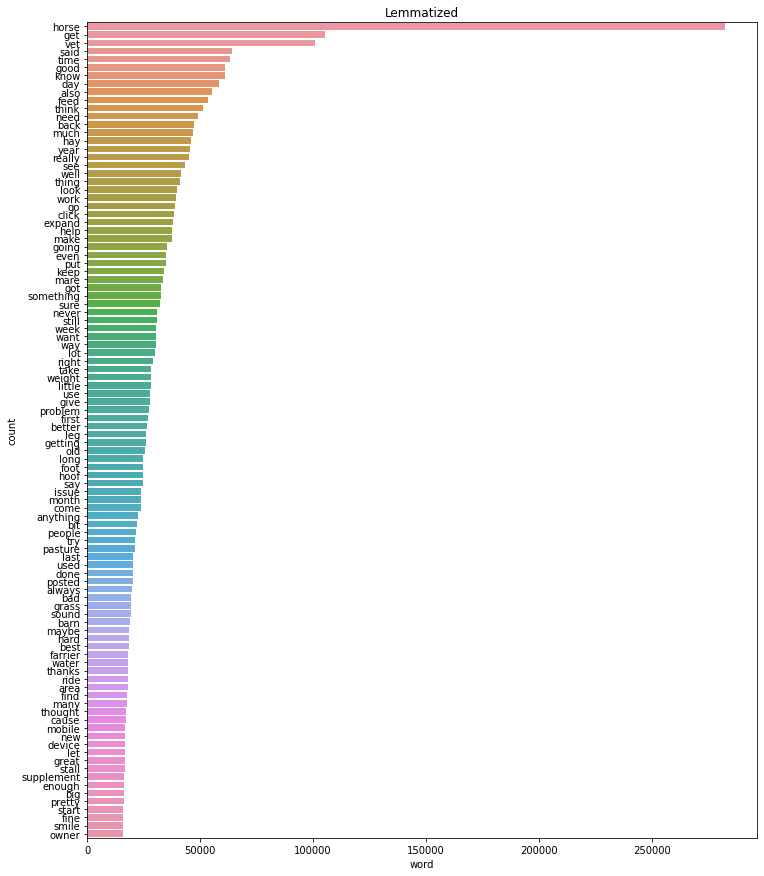

In [ ]:
# visualize words and frequencies
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 15))

# Plot Lemmatized word freq.
sns.barplot(ax=ax
            ,data=word_frequencies(df_horseforum_threads['cleaned_document_tm'], top_n = 100)
            ,x="count"
            ,y="word")

ax.set_title("Lemmatized") 
ax.set_xlabel("word")
ax.set_ylabel("count")

# Display plot
plt.show()

### Save processed corpus (optional)

The following code cells creates as a "check-point" in this data-project's workflow, due to the time required to clean the corpus.

In [ ]:
# Save dataframe locally
df_horseforum_threads[['thread_url_path', 'thread_document', 'cleaned_document', 'cleaned_document_tm']].to_csv(os.path.join(filepath_data, filename_horseforum_threads_cleaned_df), index=False)

**Reload cleaned corpus**

In [ ]:
#df_horseforum_threads = pd.read_csv(os.path.join(filepath_data, filename_horseforum_threads_cleaned_df))
#df_horseforum_threads.fillna('', inplace=True)
#df_horseforum_threads.shape

### Term weights

Term weights were calculated as *term frequency-inverse document frequency* (TF-IDF).

* Bigrams were also determined and included.

#### Bigrams

In [ ]:
%%time

# Convert each thread's document into a list of words
corpus_documents = df_horseforum_threads['cleaned_document_tm'].values.tolist()
corpus_documents = [word_tokenize(document) for document in corpus_documents]

# Build the bigram model
bigram_phrases = gensim.models.Phrases(corpus_documents, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_phraser = gensim.models.phrases.Phraser(bigram_phrases)
def set_bigrams(corpus):
    return [bigram_phraser[document] for document in corpus]

# Add bigrams
corpus_document_tokens = set_bigrams(corpus_documents)

CPU times: user 2min 9s, sys: 1.82 s, total: 2min 11s
Wall time: 2min 11s


#### TF-IDF

In [ ]:
%%time
#LDA topic model requires two things: the dictionary(id2word) and the corpus
# Create Dictionary
corpus_dict = corpora.Dictionary(corpus_document_tokens)

#filtering words less frequent and high frequent
corpus_dict.filter_extremes(no_below=100, no_above=0.75, keep_n=150000)

# Term Document Frequency (Bag of Words Approach)
corpus_bow = [corpus_dict.doc2bow(document) for document in corpus_document_tokens]
tfidf = gensim.models.TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

CPU times: user 16.3 s, sys: 360 ms, total: 16.7 s
Wall time: 16.7 s


In [ ]:
# Inspect some of the dictionary entries
count = 0
for key, value in corpus_dict.iteritems():
    print(key, value)
    count += 1
    if count > 10:
        break

0 abuse
1 add
2 added
3 adding
4 allow
5 allowed
6 allows
7 answer
8 approach
9 ask
10 aware


### LDA Model

The following was a preliminary fit of an LDA model to the corpus, to understanding its working, and observe some of the topics modelled.

It was later superseded by a subsequent LDA model (produced in the section below), derived via tuning of hyperparameters.

In [ ]:
%%time
# Building the LDA topic model
lda_model = gensim.models.LdaMulticore(
    corpus=corpus_tfidf
    ,id2word=corpus_dict    
    ,num_topics=20
    ,passes=4
    ,random_state=987
    ,per_word_topics=True
    ,workers=4
    )

CPU times: user 3min 47s, sys: 8.75 s, total: 3min 55s
Wall time: 4min 34s


In [ ]:
%%time
# Print the Keywords in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus_tfidf]

[(0,
  '0.034*"blanket" + 0.013*"water" + 0.013*"cold" + 0.011*"winter" + '
  '0.010*"coat" + 0.009*"drink" + 0.008*"sweat" + 0.007*"shelter" + '
  '0.007*"sheet" + 0.007*"warm"'),
 (1,
  '0.003*"ocd" + 0.003*"crippled" + 0.002*"laminitis" + 0.002*"leg" + '
  '0.001*"vet" + 0.001*"farrier" + 0.001*"hay" + 0.001*"teeth" + '
  '0.001*"muscle" + 0.001*"shoe"'),
 (2,
  '0.002*"sarcoid" + 0.002*"supplement" + 0.002*"tick" + 0.002*"loving" + '
  '0.002*"joint" + 0.002*"pony" + 0.002*"msm" + 0.002*"udder" + '
  '0.002*"wondering" + 0.002*"feed"'),
 (3,
  '0.033*"cribbing" + 0.022*"crib" + 0.012*"collar" + 0.011*"cribber" + '
  '0.010*"wood" + 0.007*"chew" + 0.007*"chewing" + 0.007*"wart" + 0.007*"salt" '
  '+ 0.007*"boredom"'),
 (4,
  '0.013*"feed" + 0.011*"hay" + 0.008*"weight" + 0.006*"grain" + '
  '0.006*"alfalfa" + 0.005*"feeding" + 0.005*"supplement" + 0.005*"grass" + '
  '0.005*"pellet" + 0.005*"beet_pulp"'),
 (5,
  '0.006*"height" + 0.004*"string" + 0.003*"elbow" + 0.003*"measure" + '


In [ ]:
%%time
#Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus_document_tokens, dictionary=corpus_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print()


Perplexity:  -8.955375551637859

Coherence Score:  0.5471759586203258

CPU times: user 6min 24s, sys: 1min 12s, total: 7min 37s
Wall time: 6min 16s


In [ ]:
# Demonstrate model output
for c in lda_model[corpus_tfidf[200:203]]:
    print("Document Topics      : ", c[0])      # [(Topics, Perc Contrib)]
    print("Word id, Topics      : ", c[1][:3])  # [(Word id, [Topics])]
    print("Phi Values (word id) : ", c[2][:2])  # [(Word id, [(Topic, Phi Value)])]
    print("Word, Topics         : ", [(corpus_dict[wd], topic) for wd, topic in c[1][:2]])   # [(Word, [Topics])]
    print("Phi Values (word)    : ", [(corpus_dict[wd], topic) for wd, topic in c[2][:2]])  # [(Word, [(Topic, Phi Value)])]
    print("------------------------------------------------------\n")

Document Topics      :  [(17, 0.62209195), (18, 0.2876175)]
Word id, Topics      :  [(7, [17, 18]), (15, [17, 18]), (44, [])]
Phi Values (word id) :  [(7, [(17, 0.023446219), (18, 0.0115382075)]), (15, [(17, 0.013043274), (18, 0.012053266)])]
Word, Topics         :  [('answer', [17, 18]), ('called', [17, 18])]
Phi Values (word)    :  [('answer', [(17, 0.023446219), (18, 0.0115382075)]), ('called', [(17, 0.013043274), (18, 0.012053266)])]
------------------------------------------------------

Document Topics      :  [(18, 0.93796796)]
Word id, Topics      :  [(12, [18]), (13, [18]), (17, [])]
Phi Values (word id) :  [(12, [(18, 0.022659974)]), (13, [(18, 0.03943657)])]
Word, Topics         :  [('beneficial', [18]), ('better', [18])]
Phi Values (word)    :  [('beneficial', [(18, 0.022659974)]), ('better', [(18, 0.03943657)])]
------------------------------------------------------

Document Topics      :  [(18, 0.89130056)]
Word id, Topics      :  [(5, [18]), (19, [18]), (37, [18])]
Phi 

In [ ]:
# Display top 'n' words for a specific topic
lda_model.show_topic(15,topn=15)

[('eye', 0.0024417036),
 ('fish', 0.0018604682),
 ('everyones', 0.0016634893),
 ('abs', 0.0014639957),
 ('wound', 0.0013550447),
 ('hay', 0.0012605097),
 ('vet', 0.0012604508),
 ('thought', 0.0012409256),
 ('fly', 0.0011621524),
 ('feed', 0.0010895176),
 ('skin', 0.0010209617),
 ('uveitis', 0.0009766361),
 ('wondering', 0.0009614488),
 ('water', 0.0009073765),
 ('look', 0.00088214705)]

### Hypertune LDA

This sections runs multiple LDA models to determine the best selection for the number of topcis (i.e., `num_topics`).

In [ ]:
%%time
# Hypertune number of topics
num_topics_seq = [x for x in range(4, 25, 2)]
print("Hypertune `num_topics`, seqeunce:", num_topics_seq)
model_list, coherence_values = hypertune_LDA_num_topics(dictionary=corpus_dict, corpus=corpus_tfidf, texts=corpus_document_tokens, num_topics_seq = num_topics_seq)
print()

Hypertune `num_topics`, seqeunce: [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
Modeling 4 topics...
Modeling 6 topics...
Modeling 8 topics...
Modeling 10 topics...
Modeling 12 topics...
Modeling 14 topics...
Modeling 16 topics...
Modeling 18 topics...
Modeling 20 topics...
Modeling 22 topics...
Modeling 24 topics...
...completed

CPU times: user 1h 1min 55s, sys: 42.5 s, total: 1h 2min 37s
Wall time: 1h 5min 24s


Best model: 16 topics (coherence = 0.5448)


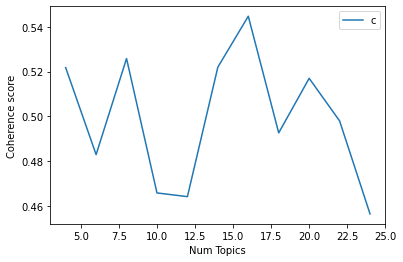

4 topics: coherance = 0.5218
6 topics: coherance = 0.4829
8 topics: coherance = 0.5259
10 topics: coherance = 0.4657
12 topics: coherance = 0.464
14 topics: coherance = 0.522
16 topics: coherance = 0.5448
18 topics: coherance = 0.4926
20 topics: coherance = 0.517
22 topics: coherance = 0.4979
24 topics: coherance = 0.4563


In [ ]:
# Select best model trialed
max_coherence = max(coherence_values)
index_max_coherence = coherence_values.index(max_coherence)
best_num_topics = num_topics_seq[index_max_coherence]
best_model = model_list[index_max_coherence]
print("Best model: {} topics (coherence = {})".format(best_num_topics, round(max_coherence, 4)))

# Show model results
plt.plot(num_topics_seq, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for n, coherence in zip(num_topics_seq, coherence_values):
    print("{} topics: coherence = {}".format(n, round(coherence, 4)))

In [ ]:
# Select best model trialed and print the topics
model_topics = best_model.show_topics(formatted=False)
pprint(best_model.print_topics(num_words=10))

[(0,
  '0.009*"feed" + 0.006*"hay" + 0.005*"supplement" + 0.005*"weight" + '
  '0.004*"grain" + 0.004*"alfalfa" + 0.003*"beet_pulp" + 0.003*"feeding" + '
  '0.003*"pellet" + 0.003*"ulcer"'),
 (1,
  '0.012*"teeth" + 0.007*"dentist" + 0.005*"wolf_teeth" + 0.004*"mouth" + '
  '0.004*"tooth" + 0.004*"sedation" + 0.004*"equine_dentist" + 0.003*"float" + '
  '0.003*"canine" + 0.003*"dental"'),
 (2,
  '0.004*"farrier" + 0.003*"hoof" + 0.003*"shoe" + 0.003*"foot" + 0.002*"vet" '
  '+ 0.002*"animal" + 0.002*"people" + 0.002*"owner" + 0.002*"care" + '
  '0.002*"feed"'),
 (3,
  '0.010*"hay" + 0.007*"grass" + 0.006*"feed" + 0.005*"weight" + '
  '0.004*"alfalfa" + 0.004*"pasture" + 0.004*"bale" + 0.003*"grain" + '
  '0.003*"feeding" + 0.003*"eat"'),
 (4,
  '0.013*"hoof" + 0.010*"shoe" + 0.009*"farrier" + 0.009*"foot" + '
  '0.006*"thrush" + 0.006*"trim" + 0.006*"barefoot" + 0.005*"frog" + '
  '0.005*"boot" + 0.004*"heel"'),
 (5,
  '0.005*"cribbing" + 0.003*"crib" + 0.003*"muscle" + 0.003*"weight" +

In [ ]:
# Demonstrate model output
for c in best_model[corpus_tfidf[200:203]]:
    print("Document Topics      : ", c[0])      # [(Topics, Perc Contrib)]
    print("Word id, Topics      : ", c[1][:3])  # [(Word id, [Topics])]
    print("Phi Values (word id) : ", c[2][:2])  # [(Word id, [(Topic, Phi Value)])]
    print("Word, Topics         : ", [(corpus_dict[wd], topic) for wd, topic in c[1][:2]])   # [(Word, [Topics])]
    print("Phi Values (word)    : ", [(corpus_dict[wd], topic) for wd, topic in c[2][:2]])  # [(Word, [(Topic, Phi Value)])]
    print("------------------------------------------------------\n")

Document Topics      :  [(13, 0.9059472)]
Word id, Topics      :  [(7, [13]), (15, [13]), (44, [])]
Phi Values (word id) :  [(7, [(13, 0.034984425)]), (15, [(13, 0.025096538)])]
Word, Topics         :  [('answer', [13]), ('called', [13])]
Phi Values (word)    :  [('answer', [(13, 0.034984425)]), ('called', [(13, 0.025096538)])]
------------------------------------------------------

Document Topics      :  [(2, 0.93878406)]
Word id, Topics      :  [(12, [2]), (13, [2]), (17, [])]
Phi Values (word id) :  [(12, [(2, 0.022659972)]), (13, [(2, 0.039436575)])]
Word, Topics         :  [('beneficial', [2]), ('better', [2])]
Phi Values (word)    :  [('beneficial', [(2, 0.022659972)]), ('better', [(2, 0.039436575)])]
------------------------------------------------------

Document Topics      :  [(0, 0.41844097), (12, 0.4814411)]
Word id, Topics      :  [(5, [12, 0]), (19, [0, 12]), (37, [12, 0])]
Phi Values (word id) :  [(5, [(0, 0.02312895), (12, 0.03566917)]), (19, [(0, 0.06939795), (12, 0.0

### Label thread topics

For each thread, identify the dominant topic(s).

In [ ]:
%%time
df_thread_topic_labels = get_lda_dominant_topics(best_model, corpus_tfidf, top_n_words=10, delim_words=', ')

CPU times: user 7min 14s, sys: 1min 44s, total: 8min 58s
Wall time: 7min 11s


In [ ]:
# Display topic labels for each thread
df_thread_topic_labels

,index_doc,Primary_topic,Primary_topic_contribution,Primary_topic_keywords,Secondary_topic,Secondary_topic_contribution,Secondary_topic_keywords
0,0,2,0.900392,"farrier, hoof, shoe, foot, vet, animal, people...",-1,0.000000,
1,1,2,0.669324,"farrier, hoof, shoe, foot, vet, animal, people...",3,0.247640,"hay, grass, feed, weight, alfalfa, pasture, ba..."
2,2,2,0.967960,"farrier, hoof, shoe, foot, vet, animal, people...",-1,0.000000,
3,3,14,0.552667,"fly, blanket, spray, skin, eye, hair, rain_rot...",10,0.406370,"wound, leg, clean, sheath, proud_flesh, cut, w..."
4,4,2,0.479670,"farrier, hoof, shoe, foot, vet, animal, people...",0,0.472672,"feed, hay, supplement, weight, grain, alfalfa,..."
...,...,...,...,...,...,...,...
20949,20949,13,0.898715,"leg, lame, joint, lameness, arthritis, hock, v...",-1,0.000000,
20950,20950,0,0.934872,"feed, hay, supplement, weight, grain, alfalfa,...",-1,0.000000,
20951,20951,2,0.899379,"farrier, hoof, shoe, foot, vet, animal, people...",-1,0.000000,
20952,20952,0,0.911793,"feed, hay, supplement, weight, grain, alfalfa,...",-1,0.000000,


In [ ]:
# Combine with main dataset
df_horseforum_threads = df_horseforum_threads.join(df_thread_topic_labels.drop(['index_doc'], axis=1))
df_horseforum_threads.head()

,thread_title,thread_url_path,thread_created_date,thread_created_by,thread_created_by_url_path,thread_view_count,thread_reply_count,thread_last_replied_date,thread_last_replied_by,thread_last_replied_by_url_path,participant_count,post_text,thread_document,cleaned_document,cleaned_document_tm,Primary_topic,Primary_topic_contribution,Primary_topic_keywords,Secondary_topic,Secondary_topic_contribution,Secondary_topic_keywords
0,PLEASE READ BEFORE POSTING (both older and new...,/threads/please-read-before-posting-both-older...,2020-12-27T19:19:33-0500,TaMMa89,/members/tamma89.3542/,1076,0,2020-12-27T19:19:33-0500,TaMMa89,/members/tamma89.3542/,1,[New Horseforum.com format was launched in Nov...,PLEASE READ BEFORE POSTING (both older and new...,PLEASE READ BEFORE POSTING (both older and new...,please read posting older newer horseforum com...,2,0.900392,"farrier, hoof, shoe, foot, vet, animal, people...",-1,0.000000,
1,poisonous plants from HF member locations,/threads/poisonous-plants-from-hf-member-locat...,2018-01-01T22:03:05-0500,Smilie,/members/smilie.18361/,2151,5,2020-12-08T16:29:12-0500,stevenson,/members/stevenson.26572/,5,[MOD NOTE (Jaydee)\n\nPlease could we keep thi...,poisonous plants from HF member locations\nMOD...,poisonous plants from HF member locations MOD ...,poisonous plant hf member location mod note ja...,2,0.669324,"farrier, hoof, shoe, foot, vet, animal, people...",3,0.247640,"hay, grass, feed, weight, alfalfa, pasture, ba..."
2,The Care of an Emaciated Horse,/threads/the-care-of-an-emaciated-horse.100412/,2011-10-14T09:02:04-0400,xxBarry Godden,/members/xxbarry-godden.9451/,48970,54,2020-11-26T10:09:30-0500,horselovinguy,/members/horselovinguy.79162/,31,"[My friend and I, both experienced horse peopl...",The Care of an Emaciated Horse\nMy friend and ...,The Care of an Emaciated Horse My friend and I...,care emaciated horse friend experienced horse ...,2,0.967960,"farrier, hoof, shoe, foot, vet, animal, people...",-1,0.000000,
3,Making a Vet Kit,/threads/making-a-vet-kit.251/,2007-01-07T02:14:09-0500,Skippy!,/members/skippy.157/,2091441,277,2019-08-26T04:44:59-0400,AmiraAchek,/members/amiraachek.280747/,215,[Hey guys! I am posting this thread primarily ...,Making a Vet Kit\nHey guys! I am posting this ...,Making a Vet Kit Hey guys! I am posting this t...,making vet kit hey guy posting thread primaril...,14,0.552667,"fly, blanket, spray, skin, eye, hair, rain_rot...",10,0.406370,"wound, leg, clean, sheath, proud_flesh, cut, w..."
4,"Information on Myopathies - PSSM1, PSSM2, MFM,...",/threads/information-on-myopathies-pssm1-pssm2...,2017-08-17T20:06:14-0400,Espy,/members/espy.168162/,17546,5,2018-09-17T16:44:33-0400,Espy,/members/espy.168162/,2,"[PSSM1, PSSM2, MFM, and RER\n\n\n\n\n\nThe sym...","Information on Myopathies - PSSM1, PSSM2, MFM,...","Information on Myopathies - PSSM1, PSSM2, MFM,...",information myopathy pssm1 pssm2 mfm rer pssm1...,2,0.479670,"farrier, hoof, shoe, foot, vet, animal, people...",0,0.472672,"feed, hay, supplement, weight, grain, alfalfa,..."


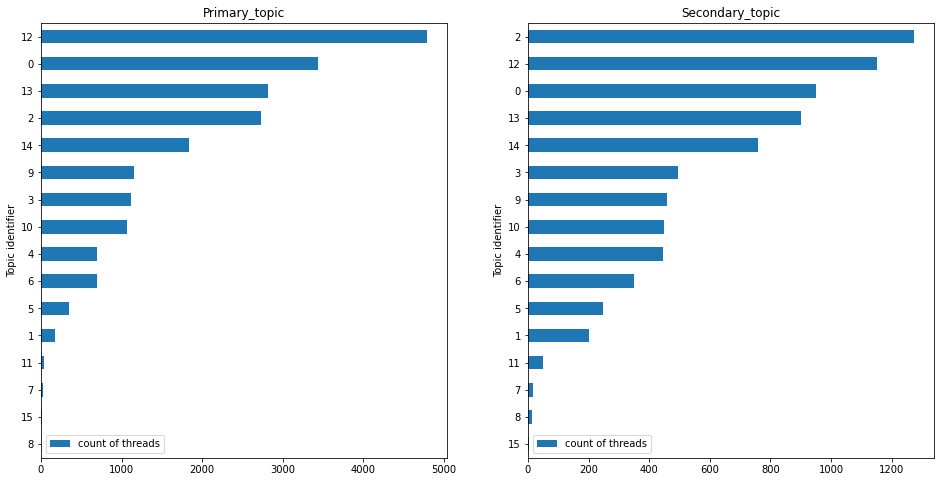

In [ ]:
# Generate frequnecy plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Primary topic
tmp_df = df_horseforum_threads['Primary_topic'].value_counts().to_frame('count of threads').sort_values('count of threads', ascending=True)
if tmp_df.shape[0] <= 20:
    tmp_df.plot.barh(ax=ax[0], title = 'Primary_topic', xlabel = "Topic identifier", ylabel="Number of threads")
else:
    tmp_df.tail(20).plot.barh(ax=ax[0], title = 'Primary_topic' + ' (top 20 of ' + str(tmp_df.shape[0]) + ' only)', xlabel = "Topic identifier", ylabel="Number of threads")

# Secondary topic
tmp_df = df_horseforum_threads[df_horseforum_threads['Secondary_topic'] !=-1]['Secondary_topic'].value_counts().to_frame('count of threads').sort_values('count of threads', ascending=True)
if tmp_df.shape[0] <= 20:
    tmp_df.plot.barh(ax=ax[1], title = 'Secondary_topic', xlabel = "Topic identifier", ylabel="Number of threads")
else:
    tmp_df.tail(20).plot.barh(ax=ax[1], title = 'Secondary_topic' + ' (top 20 of ' + str(tmp_df.shape[0]) + ' only)', xlabel = "Topic identifier", ylabel="Number of threads") 

plt.show()

In [ ]:
df_horseforum_threads['Primary_topic'].value_counts().to_frame('count of threads').sort_values('count of threads', ascending=False)

,count of threads
12,4795
0,3435
13,2818
2,2726
14,1833
9,1160
3,1123
10,1072
4,694
6,690


## NLP - Sentiment analysis

### Polarity scores per thread

Calculate sentiment polarity scores for each thread.

In [ ]:
%%time
sid = SentimentIntensityAnalyzer()
thread_sentiment = df_horseforum_threads['cleaned_document'].apply(sid.polarity_scores)

CPU times: user 10min 7s, sys: 2.72 s, total: 10min 10s
Wall time: 10min 11s


### Sentiment by thread

Convert `compound` metric into a categorical variable for sentiment (based on nominated criteria):

* if `compound` >= 0.05 then: *'positive'*
* else if `compound` <= -0.05 then: *'negative'*
* else: *'neutral'*

In [ ]:
# Get sentiment values
senitments = list(sentiment_colours().keys())
print("sentiments:", senitments)

df_thread_sentiment = pd.DataFrame(list(thread_sentiment))
df_thread_sentiment['sentiment'] = np.select(
    [
        df_thread_sentiment['compound'].ge(0.05)
        ,df_thread_sentiment['compound'].le(-0.05)
    ],
    [
        senitments[0] # "positive"
        ,senitments[2] # "negative"
    ], 
    default = senitments[1] # "neutral"
)
df_thread_sentiment

sentiments: ['positive', 'neutral', 'negative']


,neg,neu,pos,compound,sentiment
0,0.088,0.800,0.111,0.5739,positive
1,0.087,0.824,0.089,-0.6919,negative
2,0.095,0.751,0.155,1.0000,positive
3,0.053,0.773,0.174,1.0000,positive
4,0.126,0.798,0.076,-0.9997,negative
...,...,...,...,...,...
20949,0.103,0.798,0.099,-0.4244,negative
20950,0.054,0.754,0.192,0.9997,positive
20951,0.045,0.790,0.165,0.9927,positive
20952,0.053,0.738,0.209,0.9990,positive


#### Frequency plot

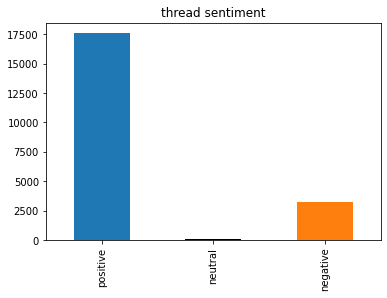

In [ ]:
color_sentiment = sentiment_colours()
fig, ax = plt.subplots(nrows=1,ncols=1)
df_thread_sentiment['sentiment'].value_counts().reindex(color_sentiment.keys()).plot(ax = ax, kind='bar',title="thread sentiment", color = color_sentiment.values())
plt.show()

### Sentiment by topics

In [ ]:
# turn the result into a data frame and add as columns to the original data
df_horseforum_threads = df_horseforum_threads.join(df_thread_sentiment)

In [ ]:
df_horseforum_threads.head()

,thread_title,thread_url_path,thread_created_date,thread_created_by,thread_created_by_url_path,thread_view_count,thread_reply_count,thread_last_replied_date,thread_last_replied_by,thread_last_replied_by_url_path,participant_count,post_text,thread_document,cleaned_document,cleaned_document_tm,Primary_topic,Primary_topic_contribution,Primary_topic_keywords,Secondary_topic,Secondary_topic_contribution,Secondary_topic_keywords,neg,neu,pos,compound,sentiment
0,PLEASE READ BEFORE POSTING (both older and new...,/threads/please-read-before-posting-both-older...,2020-12-27T19:19:33-0500,TaMMa89,/members/tamma89.3542/,1076,0,2020-12-27T19:19:33-0500,TaMMa89,/members/tamma89.3542/,1,[New Horseforum.com format was launched in Nov...,PLEASE READ BEFORE POSTING (both older and new...,PLEASE READ BEFORE POSTING (both older and new...,please read posting older newer horseforum com...,2,0.900392,"farrier, hoof, shoe, foot, vet, animal, people...",-1,0.000000,,0.088,0.800,0.111,0.5739,positive
1,poisonous plants from HF member locations,/threads/poisonous-plants-from-hf-member-locat...,2018-01-01T22:03:05-0500,Smilie,/members/smilie.18361/,2151,5,2020-12-08T16:29:12-0500,stevenson,/members/stevenson.26572/,5,[MOD NOTE (Jaydee)\n\nPlease could we keep thi...,poisonous plants from HF member locations\nMOD...,poisonous plants from HF member locations MOD ...,poisonous plant hf member location mod note ja...,2,0.669324,"farrier, hoof, shoe, foot, vet, animal, people...",3,0.247640,"hay, grass, feed, weight, alfalfa, pasture, ba...",0.087,0.824,0.089,-0.6919,negative
2,The Care of an Emaciated Horse,/threads/the-care-of-an-emaciated-horse.100412/,2011-10-14T09:02:04-0400,xxBarry Godden,/members/xxbarry-godden.9451/,48970,54,2020-11-26T10:09:30-0500,horselovinguy,/members/horselovinguy.79162/,31,"[My friend and I, both experienced horse peopl...",The Care of an Emaciated Horse\nMy friend and ...,The Care of an Emaciated Horse My friend and I...,care emaciated horse friend experienced horse ...,2,0.967960,"farrier, hoof, shoe, foot, vet, animal, people...",-1,0.000000,,0.095,0.751,0.155,1.0000,positive
3,Making a Vet Kit,/threads/making-a-vet-kit.251/,2007-01-07T02:14:09-0500,Skippy!,/members/skippy.157/,2091441,277,2019-08-26T04:44:59-0400,AmiraAchek,/members/amiraachek.280747/,215,[Hey guys! I am posting this thread primarily ...,Making a Vet Kit\nHey guys! I am posting this ...,Making a Vet Kit Hey guys! I am posting this t...,making vet kit hey guy posting thread primaril...,14,0.552667,"fly, blanket, spray, skin, eye, hair, rain_rot...",10,0.406370,"wound, leg, clean, sheath, proud_flesh, cut, w...",0.053,0.773,0.174,1.0000,positive
4,"Information on Myopathies - PSSM1, PSSM2, MFM,...",/threads/information-on-myopathies-pssm1-pssm2...,2017-08-17T20:06:14-0400,Espy,/members/espy.168162/,17546,5,2018-09-17T16:44:33-0400,Espy,/members/espy.168162/,2,"[PSSM1, PSSM2, MFM, and RER\n\n\n\n\n\nThe sym...","Information on Myopathies - PSSM1, PSSM2, MFM,...","Information on Myopathies - PSSM1, PSSM2, MFM,...",information myopathy pssm1 pssm2 mfm rer pssm1...,2,0.479670,"farrier, hoof, shoe, foot, vet, animal, people...",0,0.472672,"feed, hay, supplement, weight, grain, alfalfa,...",0.126,0.798,0.076,-0.9997,negative


#### Plot sentiment ratios by topic

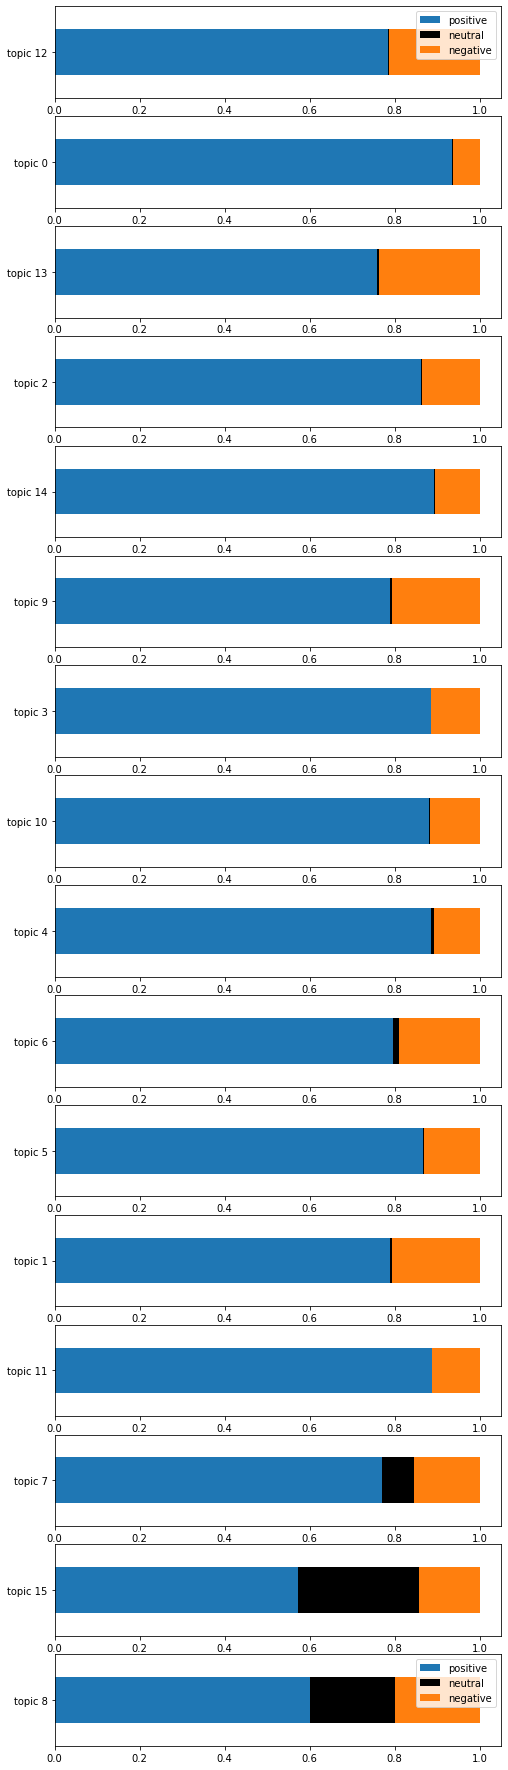

In [ ]:
# Show relative sentiment proportion for each topic
tmp_df = df_horseforum_threads['Primary_topic'].value_counts().to_frame('count of threads').sort_values('count of threads', ascending=False)

color_sentiment = sentiment_colours()
n = len(tmp_df.index)
fig, ax = plt.subplots(nrows=n, ncols=1, figsize=(8, 2*n))
for i, topic_id in enumerate(tmp_df.index):
    tmp = df_horseforum_threads[df_horseforum_threads['Primary_topic']==topic_id]['sentiment'].value_counts().reindex(color_sentiment.keys()).fillna(0).to_frame('topic {}'.format(topic_id)).apply(lambda x: x / sum(x))
    tmp.transpose().plot(ax = ax[i], kind='barh',stacked = True, color = color_sentiment.values())
    if i != 0 and i != (n-1):
        ax[i].get_legend().remove()
plt.show()

By observation, Topic Id = `13` was amongst the topics with the largest proportion of negative sentiment.

In [ ]:
best_model.show_topic(topicid=13 ,topn=10)

[('leg', 0.0054481574),
 ('lame', 0.004644456),
 ('joint', 0.004512162),
 ('lameness', 0.004149157),
 ('arthritis', 0.0037241387),
 ('hock', 0.0036727479),
 ('vet', 0.0036025518),
 ('injury', 0.0034467615),
 ('stifle', 0.0031788195),
 ('foot', 0.0030942804)]

## Python notebook (.ipynb) conversion


In [50]:
# Set notebooks full filename & path
filename_Notebook_ipynb = 'A3_Deliverable_3_Lachlan_Sharp.ipynb'
filename_Notebook_ipynb = '\"' + os.path.join(filepath_root, filename_Notebook_ipynb) + '\"'

### Convert to HTML

The following code cell was for converting this Python notebook (.ipynb) to HTML (.html).

In [60]:
# Conversion of notebook to html (Google Colab):
!jupyter nbconvert --to html $filename_Notebook_ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/MA5851/Assessment 3/A3_Deliverable_3_Lachlan_Sharp.ipynb to html
[NbConvertApp] Writing 713758 bytes to /content/drive/MyDrive/Colab Notebooks/MA5851/Assessment 3/A3_Deliverable_3_Lachlan_Sharp.html


### Convert to PDF

The following code cell was for converting this Python notebook (.ipynb) to PDF (.pdf).



In [53]:
# Install pandoc in order to render PDF (suppress output)
%%capture
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [59]:
# Conversion of notebook to pdf (Google Colab):
!jupyter nbconvert --to PDF A3_Deliverable_3_Lachlan_Sharp.ipynb

[NbConvertApp] Converting notebook A3_Deliverable_3_Lachlan_Sharp.ipynb to PDF
[NbConvertApp] Support files will be in A3_Deliverable_3_Lachlan_Sharp_files/
[NbConvertApp] Making directory ./A3_Deliverable_3_Lachlan_Sharp_files
[NbConvertApp] Making directory ./A3_Deliverable_3_Lachlan_Sharp_files
[NbConvertApp] Making directory ./A3_Deliverable_3_Lachlan_Sharp_files
[NbConvertApp] Making directory ./A3_Deliverable_3_Lachlan_Sharp_files
[NbConvertApp] Making directory ./A3_Deliverable_3_Lachlan_Sharp_files
[NbConvertApp] Writing 183667 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 378129 bytes to A3_Deliverable_3_Lachlan_Sharp.pdf
